In [40]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/home/hrai/codes/PoseAdaptor')
from lib_import import *
from my_utils import *
os.chdir('/home/hrai/codes/extrinsic_calibration')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
logitech_intrinsic = np.array([[626.50494838, 0., 311.09117891],
                               [  0. ,627.50681747, 233.49381065 ],
                               [  0., 0., 1.]])
distCoeff = np.array([ 0.1589167,  -1.23062865,  0.00901355,  0.01334335])

In [42]:
# https://house-of-e.tistory.com/entry/9-OpenCV-python-%EB%A7%88%EC%9A%B0%EC%8A%A4-%EB%8F%99%EC%9E%91-%ED%95%A8%EC%88%98-setMouseCallback 
class MouseGesture():
    def __init__(self) -> None:
        self.is_dragging = False 
        self.x0, self.y0, self.w0, self.h0 = -1,-1,-1,-1
        self.saved_frames = []
        self.saved_pixels = []

    def on_mouse(self, event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            #print("왼쪽 버튼 눌림 \t좌표 : x : {} y : {}".format(x,y) )
            pass
        elif event == cv2.EVENT_LBUTTONUP:
            #print("왼쪽 버튼 올림\t좌표 : x : {} y : {}".format(x,y) )
            pass
        elif event == cv2.EVENT_RBUTTONDOWN:
            #print("오른쪽 버튼 눌림\t좌표 : x : {} y : {}".format(x,y) )
            print("{}, {} saved".format(x, y))
            self.saved_frames.append(param)
            self.saved_pixels.append([x,y])
        # elif event == cv2.EVENT_RBUTTONUP:
        #     print("오른쪽 버튼 올림\t좌표 : x : {} y : {}".format(x,y) )    
        # elif event == cv2.EVENT_MBUTTONDOWN:
        #     print("가운데 버튼 내림\t좌표 : x : {} y : {}".format(x,y) )
        # elif event == cv2.EVENT_MBUTTONUP:
        #     print("가운데 버튼 올림\t좌표 : x : {} y : {}".format(x,y) )
        # # elif event == cv2.EVENT_MOUSEMOVE:
        # #     # 마우스 움직임은 너무 많이 나와서 생략    
        # #     print("마우스 움직임\t좌표 : x : {} y : {}".format(x,y) )
        # elif event == cv2.EVENT_MOUSEHWHEEL:
        #     # 가로휠이 없는 마우스라 .... 
        #     print("마우스 가로 휠 \t좌표 : x : {} y : {}".format(x,y) )
        # elif event == cv2.EVENT_MOUSEWHEEL:
        #     print("마우스 그냥 휠 \t좌표 : x : {} y : {}".format(x,y) )
            
        return 

In [78]:
capture = cv2.VideoCapture(0)
capture.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
capture.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
window_name = "VideoFrame"
mouse_class = MouseGesture()

saved_frames = []
while True:
    ret, frame = capture.read()
    cv2.imshow(window_name, frame)
    cv2.setMouseCallback(window_name, mouse_class.on_mouse, param=frame)
    key_input = cv2.waitKey(33)
    if key_input == ord('q'):
        break
    elif key_input == ord('s'):
        saved_frames.append(frame)
        cv2.imwrite('test_{}.png'.format(len(saved_frames)), frame)
        #break

capture.release()
cv2.destroyAllWindows()

[ WARN:0@3243.838] global /croot/opencv-suite_1676452025216/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created


In [34]:
corres_points = []
corres_points.append([  0,  0,  0])
corres_points.append([  0.2135,  0,  0])
corres_points.append([  0.2135,  0.1655,  0])
corres_points.append([  0,  0.1655,  0])

In [36]:
pnp_data = {"image": mouse_class.saved_frames[0],
            "saved_pixels": mouse_class.saved_pixels,
            "corres_points": corres_points,}
savepkl(pnp_data, 'pnp_data.pkl')

In [6]:
pnp_data = readpkl('pnp_data.pkl')

In [7]:
H, W, _ = pnp_data['image'].shape

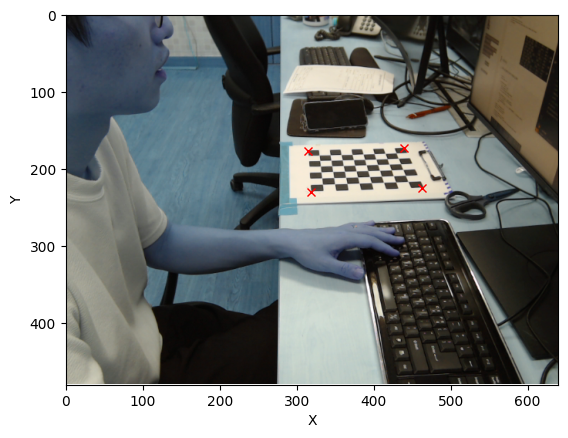

In [8]:
%matplotlib inline
fig = plt.figure(0)
ax = axes_2d(fig, H=H, W=W)
ax.imshow(pnp_data['image'])
for pixel in pnp_data['saved_pixels']:
    ax.plot(pixel[0], pixel[1], 'rx')
plt.show()

### SolvePnP - logitech

In [9]:
objPoint = np.array(pnp_data['corres_points'], dtype=np.float32)
imgPoint = np.array(pnp_data['saved_pixels'], dtype=np.float32)

In [12]:
objPoint, imgPoint

(array([[0.    , 0.    , 0.    ],
        [0.2135, 0.    , 0.    ],
        [0.2135, 0.1655, 0.    ],
        [0.    , 0.1655, 0.    ]], dtype=float32),
 array([[318., 230.],
        [463., 225.],
        [440., 173.],
        [315., 177.]], dtype=float32))

In [38]:
#solve perspective n point
_, rvec, tvec = cv2.solvePnP(objPoint, imgPoint, logitech_intrinsic, None)
tvec.reshape(3), rvec.reshape(3)

(array([ 0.01053634, -0.00525156,  0.92265355]),
 array([ 2.14716143, -0.04232147, -0.00846191]))

In [36]:
R = Rotation.from_rotvec(rvec.reshape(3)).as_matrix()
t = tvec.reshape(3)

In [37]:
C = -R.T @ t
C

array([-0.02111268, -0.78448961,  0.51052324])

In [27]:
z_x, z_y, z_z = R.T @ np.array([0,0,1])

In [31]:
pan = np.arctan2(z_y, z_x) - np.pi/2
tilt = np.arctan2(z_z, np.sqrt(z_x**2 + z_y**2))
roll = np.sign(z_z) * np.arccos(np.dot(np.array([z_x, z_y, z_z], pan))))
degrees(pan), degrees(tilt)

(-0.7129784257504501, -33.04649812885608)

### SolvePnP - s23 - 2x2

In [46]:
s23_intrinsic = np.array([[838.27548388,   0.,         420.81985372], [  0.,         834.6891153,  593.11559133], [  0.,           0.,           1.        ]])
distCoeff = np.array([ 0.07779797, -0.12779689, -0.00193088, -0.00601039,  0.05966637])

window_name = "ImageFrame"
mouse_class = MouseGesture()
frame = cv2.imread('20231108_000309.jpg')
frame = cv2.resize(frame, dsize=(0,0), fx=0.3, fy=0.3, interpolation=cv2.INTER_LINEAR)

while True:
    cv2.imshow(window_name, frame)
    cv2.setMouseCallback(window_name, mouse_class.on_mouse, param=frame)
    key_input = cv2.waitKey(33)
    if key_input == ord('q'):
        break

cv2.destroyAllWindows()

296, 746 saved
427, 844 saved
611, 761 saved
465, 690 saved


In [ ]:
corres_points = []
corres_points.append([  0,  0,  0])
corres_points.append([  0.449*2,  0,  0])
corres_points.append([  0.449*2,  0.449*2,  0])
corres_points.append([  0,  0.449*2,  0])

pnp_data = {"image": mouse_class.saved_frames[0],
            "saved_pixels": mouse_class.saved_pixels,
            "corres_points": corres_points,}
savepkl(pnp_data, 'pnp_data_s23_2x2.pkl')

pnp_data['corres_points'], pnp_data['saved_pixels']

In [97]:
pnp_data = readpkl('pnp_data_s23_2x2.pkl')

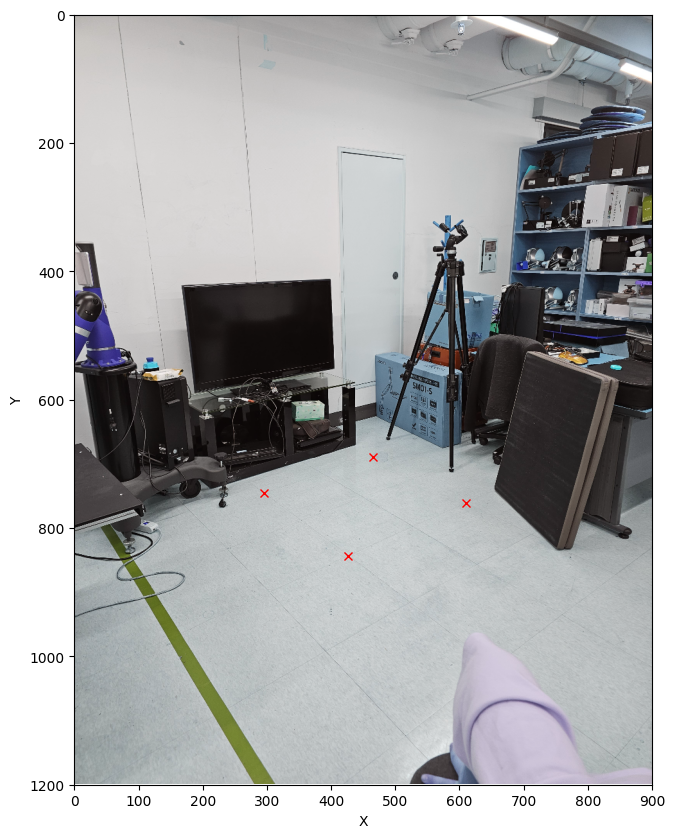

In [98]:
%matplotlib inline
H, W, _ = pnp_data['image'].shape
fig = plt.figure(2, figsize=(10,10))
ax = axes_2d(fig, H=H, W=W)
ax.imshow(pnp_data['image'])
for pixel in pnp_data['saved_pixels']:
    ax.plot(pixel[0], pixel[1], 'rx')
plt.show()

In [99]:
objPoint = np.array(pnp_data['corres_points'], dtype=np.float32)
imgPoint = np.array(pnp_data['saved_pixels'], dtype=np.float32)

#solve perspective n point
_, rvec, tvec = cv2.solvePnP(objPoint, imgPoint, s23_intrinsic, None)
R = Rotation.from_rotvec(rvec.reshape(3)).as_matrix()
t = tvec.reshape(3)
C = -R.T @ t
C, 0.449*6, -0.449*3, 1.5

(array([ 2.83963098, -1.41105569,  1.59761453]), 2.694, -1.347, 1.5)

In [100]:
z_x, z_y, z_z = R.T @ np.array([0,0,1])
pan = np.arctan2(z_y, z_x) - np.pi/2
tilt = np.arctan2(z_z, np.sqrt(z_x**2 + z_y**2))
#roll = np.sign(z_z) * np.arccos(np.dot(np.array([z_x, z_y, z_z], pan)))
degrees(pan), degrees(tilt)

(53.94564966075392, -16.913453479937413)

### 3x3

In [88]:
s23_intrinsic = np.array([[838.27548388,   0.,         420.81985372], [  0.,         834.6891153,  593.11559133], [  0.,           0.,           1.        ]])
distCoeff = np.array([ 0.07779797, -0.12779689, -0.00193088, -0.00601039,  0.05966637])

window_name = "ImageFrame"
mouse_class = MouseGesture()
frame = cv2.imread('20231108_000309.jpg')
frame = cv2.resize(frame, dsize=(0,0), fx=0.3, fy=0.3, interpolation=cv2.INTER_LINEAR)

while True:
    cv2.imshow(window_name, frame)
    cv2.setMouseCallback(window_name, mouse_class.on_mouse, param=frame)
    key_input = cv2.waitKey(33)
    if key_input == ord('q'):
        break

cv2.destroyAllWindows()

187, 781 saved
392, 993 saved
712, 810 saved
466, 690 saved


In [89]:
corres_points = []
corres_points.append([  0,  0,  0])
corres_points.append([  0.449*3,  0,  0])
corres_points.append([  0.449*3,  0.449*3,  0])
corres_points.append([  0,  0.449*3,  0])

pnp_data = {"image": mouse_class.saved_frames[0],
            "saved_pixels": mouse_class.saved_pixels,
            "corres_points": corres_points,}
savepkl(pnp_data, 'pnp_data_s23_3x3.pkl')

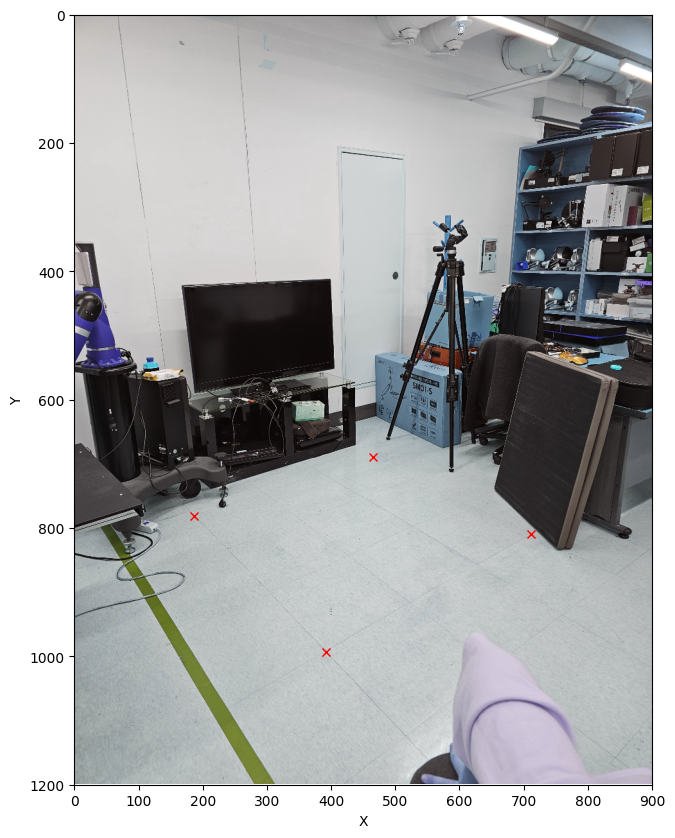

In [90]:
%matplotlib inline
H, W, _ = pnp_data['image'].shape
fig = plt.figure(3, figsize=(10,10))
ax = axes_2d(fig, H=H, W=W)
ax.imshow(pnp_data['image'])
for pixel in pnp_data['saved_pixels']:
    ax.plot(pixel[0], pixel[1], 'rx')
plt.show()

In [94]:
objPoint = np.array(pnp_data['corres_points'], dtype=np.float32)
imgPoint = np.array(pnp_data['saved_pixels'], dtype=np.float32)

#solve perspective n point
_, rvec, tvec = cv2.solvePnP(objPoint, imgPoint, s23_intrinsic, None)
R = Rotation.from_rotvec(rvec.reshape(3)).as_matrix()
t = tvec.reshape(3)
C = -R.T @ t
C, 0.449*6, -0.449*2, 1.5

(array([ 2.80053878, -0.94023533,  1.59868197]), 2.694, -0.898, 1.5)

In [95]:
z_x, z_y, z_z = R.T @ np.array([0,0,1])
pan = np.arctan2(z_y, z_x) - np.pi/2
tilt = np.arctan2(z_z, np.sqrt(z_x**2 + z_y**2))
#roll = np.sign(z_z) * np.arccos(np.dot(np.array([z_x, z_y, z_z], pan)))
degrees(pan), degrees(tilt)

(53.78199581931866, -17.2538279752898)

### 2x2 full

In [101]:
s23_intrinsic = np.array([[838.27548388,   0.,         420.81985372], [  0.,         834.6891153,  593.11559133], [  0.,           0.,           1.        ]])
distCoeff = np.array([ 0.07779797, -0.12779689, -0.00193088, -0.00601039,  0.05966637])

window_name = "ImageFrame"
mouse_class = MouseGesture()
frame = cv2.imread('20231108_000309.jpg')
frame = cv2.resize(frame, dsize=(0,0), fx=0.3, fy=0.3, interpolation=cv2.INTER_LINEAR)

while True:
    cv2.imshow(window_name, frame)
    cv2.setMouseCallback(window_name, mouse_class.on_mouse, param=frame)
    key_input = cv2.waitKey(33)
    if key_input == ord('q'):
        break

cv2.destroyAllWindows()

296, 746 saved
354, 789 saved
428, 844 saved
386, 715 saved
449, 752 saved
527, 798 saved
465, 689 saved
531, 721 saved
610, 761 saved


In [102]:
corres_points = []
corres_points.append([  0,        0,        0])
corres_points.append([  0.449*1,  0,        0])
corres_points.append([  0.449*2,  0,        0])
corres_points.append([  0,        0.449*1,  0])
corres_points.append([  0.449*1,  0.449*1,  0])
corres_points.append([  0.449*2,  0.449*1,  0])
corres_points.append([  0,        0.449*2,  0])
corres_points.append([  0.449*1,  0.449*2,  0])
corres_points.append([  0.449*2,  0.449*2,  0])

pnp_data = {"image": mouse_class.saved_frames[0],
            "saved_pixels": mouse_class.saved_pixels,
            "corres_points": corres_points,}
savepkl(pnp_data, 'pnp_data_s23_2x2_full.pkl')

pnp_data['corres_points'], pnp_data['saved_pixels']

([[0, 0, 0],
  [0.449, 0, 0],
  [0.898, 0, 0],
  [0, 0.449, 0],
  [0.449, 0.449, 0],
  [0.898, 0.449, 0],
  [0, 0.898, 0],
  [0.449, 0.898, 0],
  [0.898, 0.898, 0]],
 [[296, 746],
  [354, 789],
  [428, 844],
  [386, 715],
  [449, 752],
  [527, 798],
  [465, 689],
  [531, 721],
  [610, 761]])

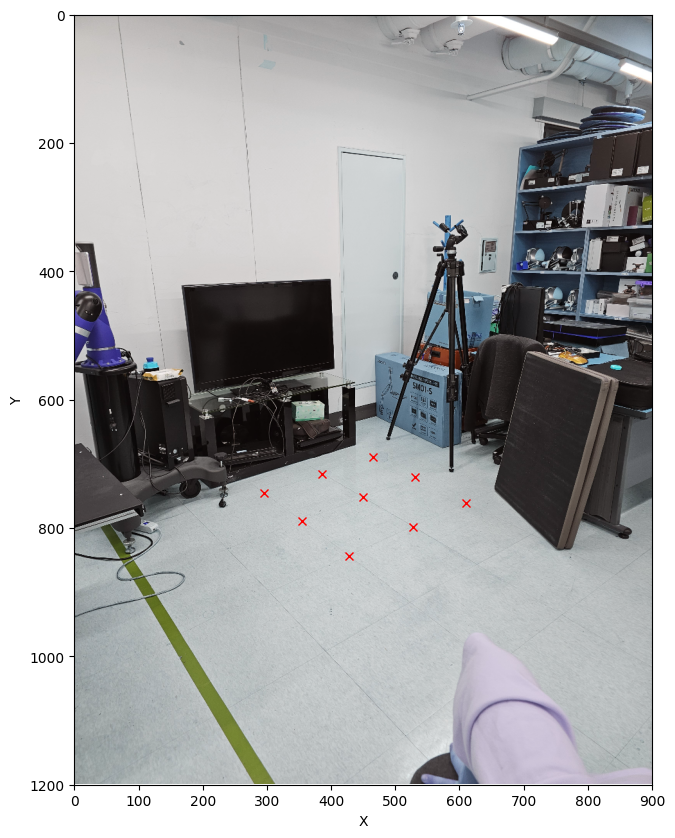

In [103]:
%matplotlib inline
H, W, _ = pnp_data['image'].shape
fig = plt.figure(3, figsize=(10,10))
ax = axes_2d(fig, H=H, W=W)
ax.imshow(pnp_data['image'])
for pixel in pnp_data['saved_pixels']:
    ax.plot(pixel[0], pixel[1], 'rx')
plt.show()

In [104]:
objPoint = np.array(pnp_data['corres_points'], dtype=np.float32)
imgPoint = np.array(pnp_data['saved_pixels'], dtype=np.float32)

#solve perspective n point
_, rvec, tvec = cv2.solvePnP(objPoint, imgPoint, s23_intrinsic, None)
R = Rotation.from_rotvec(rvec.reshape(3)).as_matrix()
t = tvec.reshape(3)
C = -R.T @ t
C, 0.449*6, -0.449*3, 1.5

(array([ 2.83239106, -1.4170459 ,  1.61198341]), 2.694, -1.347, 1.5)

### 4x3

In [116]:
s23_intrinsic = np.array([[838.27548388,   0.,         420.81985372], [  0.,         834.6891153,  593.11559133], [  0.,           0.,           1.        ]])
distCoeff = np.array([ 0.07779797, -0.12779689, -0.00193088, -0.00601039,  0.05966637])


In [115]:

window_name = "ImageFrame"
mouse_class = MouseGesture()
frame = cv2.imread('20231108_000309.jpg')
frame = cv2.resize(frame, dsize=(0,0), fx=0.3, fy=0.3, interpolation=cv2.INTER_LINEAR)

while True:
    cv2.imshow(window_name, frame)
    cv2.setMouseCallback(window_name, mouse_class.on_mouse, param=frame)
    key_input = cv2.waitKey(33)
    if key_input == ord('q'):
        break

cv2.destroyAllWindows()

In [106]:
corres_points = []
corres_points.append([  0,  0,  0])
corres_points.append([  0.449*4,  0,  0])
corres_points.append([  0.449*4,  0.449*3,  0])
corres_points.append([  0,  0.449*3,  0])

pnp_data = {"image": mouse_class.saved_frames[0],
            "saved_pixels": mouse_class.saved_pixels,
            "corres_points": corres_points,}
savepkl(pnp_data, 'pnp_data_s23_4x3.pkl')

In [122]:
pnp_data['corres_points'], pnp_data['saved_pixels']

([[0, 0, 0], [1.796, 0, 0], [1.796, 1.347, 0], [0, 1.347, 0]],
 [[188, 782], [516, 1124], [843, 873], [467, 689]])

In [117]:
pnp_data = readpkl('pnp_data_s23_4x3.pkl')

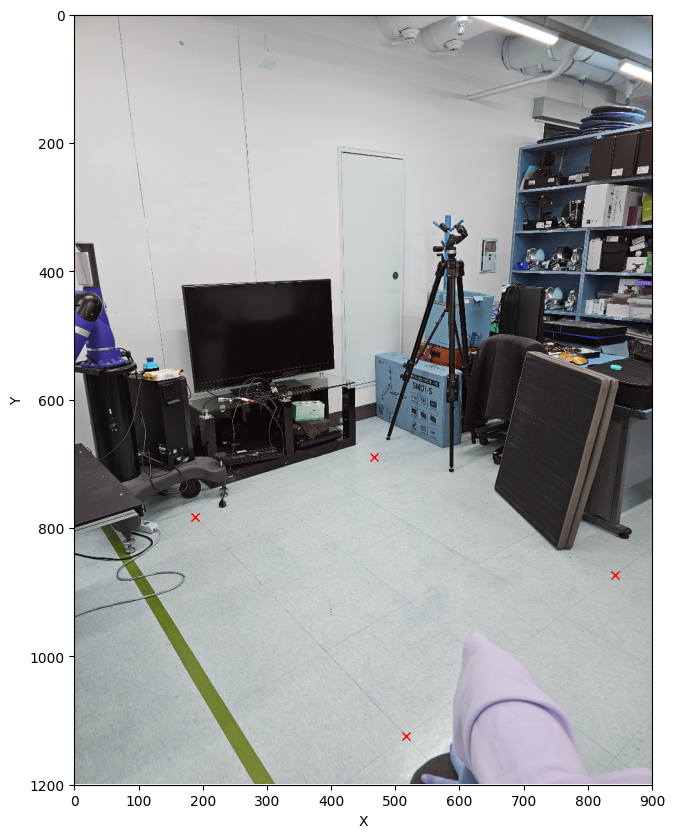

In [118]:
%matplotlib inline
H, W, _ = pnp_data['image'].shape
fig = plt.figure(4, figsize=(10,10))
ax = axes_2d(fig, H=H, W=W)
ax.imshow(pnp_data['image'])
for pixel in pnp_data['saved_pixels']:
    ax.plot(pixel[0], pixel[1], 'rx')
plt.show()

In [119]:
objPoint = np.array(pnp_data['corres_points'], dtype=np.float32)
imgPoint = np.array(pnp_data['saved_pixels'], dtype=np.float32)

#solve perspective n point
_, rvec, tvec = cv2.solvePnP(objPoint, imgPoint, s23_intrinsic, None)
R = Rotation.from_rotvec(rvec.reshape(3)).as_matrix()
t = tvec.reshape(3)
C = -R.T @ t
C, 0.449*6, -0.449*2, 1.5

(array([ 2.78303195, -0.93059406,  1.62154946]), 2.694, -0.898, 1.5)

In [120]:
z_x, z_y, z_z = R.T @ np.array([0,0,1])
pan = np.arctan2(z_y, z_x) - np.pi/2
tilt = np.arctan2(z_z, np.sqrt(z_x**2 + z_y**2))
#roll = np.sign(z_z) * np.arccos(np.dot(np.array([z_x, z_y, z_z], pan)))
degrees(pan), degrees(tilt)

(53.77304551876472, -17.755468082373916)